# Venta de autos usados Rusty Bargain

# Descripción
El servicio de venta de autos usados *Rusty Bargain* está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. 

Tenemos acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. 


## Objetivo

- Crear un modelo de machine learning que determine el valor de mercado. 
- Evaluar nuestro modelo en base a:
    - la **calidad** de la predicción
    - la **velocidad** de la predicción
    - el **tiempo** requerido para el entrenamiento

# Preparación de datos

In [1]:
%load_ext watermark
%watermark

Last updated: 2023-05-09T21:29:10.844610-05:00

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.12.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit



Importamos librerías

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model    import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics         import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

%matplotlib inline

Cargamos y visualizamos los datos:

In [3]:
# carga de datos
try:
    df = pd.read_csv('car_data.csv')
except:
    df = pd.read_csv('/datasets/car_data.csv')

In [4]:
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


El dataset contiene la siguiente información:

**Características**
- `DateCrawled` — fecha en la que se descargó el perfil de la base de datos
- `VehicleType` — tipo de carrocería del vehículo
- `RegistrationYear` — año de matriculación del vehículo
- `Gearbox` — tipo de caja de cambios
- `Power` — potencia (CV)
- `Model` — modelo del vehículo
- `Mileage` — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- `RegistrationMonth` — mes de matriculación del vehículo
- `FuelType` — tipo de combustible
- `Brand` — marca del vehículo
- `NotRepaired` — vehículo con o sin reparación
- `DateCreated` — fecha de creación del perfil
- `NumberOfPictures` — número de fotos del vehículo
- `PostalCode` — código postal del propietario del perfil (usuario)
- `LastSeen` — fecha de la última vez que el usuario estuvo activo

**Objetivo**
- `Price` — precio (en euros)

Revisemos de nuestros datos el tamaño del dataset, tipos de datos y conteo de registros por columna:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Tenemos un dataset con un tamaño inicial de 354.369 registros y 16 columnas. Observamos en el conteo de registros por columnas que tenemos ausencia de datos en 5 columnas que se deberán abordar más adelante. También tipos de datos que debemos cambiar.

Renombramos las columnas de acuerdo a la convención *snake_case*:

In [6]:
df = df.rename(columns={'DateCrawled':'date_crawled', 
                        'Price':'price', 
                        'VehicleType':'vehicle_type', 
                        'RegistrationYear':'registration_year', 
                        'Gearbox':'gearbox',
                        'Power':'power', 
                        'Model':'model', 
                        'Mileage':'mileage', 
                        'RegistrationMonth':'registration_month', 
                        'FuelType': 'fuel_type', 
                        'Brand':'brand',
                        'NotRepaired':'not_repaired', 
                        'DateCreated':'date_created', 
                        'NumberOfPictures':'number_of_pictures', 
                        'PostalCode':'postal_code',
                        'LastSeen':'last_seen'
                        }
                )

In [7]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


Eliminamos registros duplicados:

In [8]:
df.duplicated().sum()

262

In [9]:
df.duplicated().sum() / len(df)

0.0007393423239617461

In [10]:
df = df.drop_duplicates().reset_index(drop=True)

In [11]:
df.shape

(354107, 16)

Cambiamos tipos de datos de columnas:

In [12]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%d/%m/%Y %H:%M')
df['date_created'] = pd.to_datetime(df['date_created'], format='%d/%m/%Y %H:%M')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%d/%m/%Y %H:%M')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354107 entries, 0 to 354106
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354107 non-null  datetime64[ns]
 1   price               354107 non-null  int64         
 2   vehicle_type        316623 non-null  object        
 3   registration_year   354107 non-null  int64         
 4   gearbox             334277 non-null  object        
 5   power               354107 non-null  int64         
 6   model               334406 non-null  object        
 7   mileage             354107 non-null  int64         
 8   registration_month  354107 non-null  int64         
 9   fuel_type           321218 non-null  object        
 10  brand               354107 non-null  object        
 11  not_repaired        282962 non-null  object        
 12  date_created        354107 non-null  datetime64[ns]
 13  number_of_pictures  354107 no

Revisemos estadísticas descriptivas por columna:

In [14]:
df.describe()

,date_crawled,price,registration_year,power,mileage,registration_month,date_created,number_of_pictures,postal_code,last_seen
count,354107,354107.000000,354107.000000,354107.000000,354107.000000,354107.000000,354107,354107.0,354107.000000,354107
mean,2016-03-21 12:56:48.735947008,4416.433287,2004.235355,110.089651,128211.811684,5.714182,2016-03-20 19:11:13.738728960,0.0,50507.145030,2016-03-29 23:51:12.374903808
min,2016-03-05 14:06:00,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:00
25%,2016-03-13 11:52:00,1050.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:00
50%,2016-03-21 17:50:00,2700.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49406.000000,2016-04-03 15:15:00
75%,2016-03-29 14:36:00,6400.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:06:00
max,2016-04-07 14:36:00,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:00
std,NaN,4514.338584,90.261168,189.914972,37906.590101,3.726682,NaN,0.0,25784.212094,NaN


In [15]:
df[['vehicle_type', 'gearbox','model', 'fuel_type', 'brand','not_repaired']].describe()

,vehicle_type,gearbox,model,fuel_type,brand,not_repaired
count,316623,334277,334406,321218,354107,282962
unique,8,2,250,7,40,2
top,sedan,manual,golf,petrol,volkswagen,no
freq,91399,268034,29215,216161,76960,246927


Con las estadísticas por columnas podemos revisar rápidamente como están nuestros datos. 
- `number_of_pictures` contiene solo valores cero, esta información no aporta nada, por lo que es una columna que podemos eliminar.
- `price` medio de los vehículos es de 4.416 euros. Desde valores en 0 hasta 20.0000.
- `mileage` medio de los vehículos es de 128.211 Km.
- `vehicle_type` 8 categorías, el más popular el sedan.
- `gearbox` 2 categorias, el más popular el manual.
- `fueltype` 7 categorias, el más popular el petrol.
- `brand` 40 categorías, la más popular volkswagen.
- `notrepaired` el mas popular no.
- revisaremos las columnas de fechas dejando lo necesario.

Eliminamos columnas innecesarias:

Revisaremos primero cuales son las columnas a eliminar, realizaremos lo siguiente:
-  Comprobaremos si las columnas `date_crawled` y `date_created` tienen las mismas fechas, de ser cierto, eliminaremos `date_crawled` y nos quedaremos con `date_created`.
-  La columna `registration_month` nos da el mes de matriculación, información que consideramos irrelevante para este trabajo, por lo que se eliminará.
-  La columna `number_of_pictures` vimos que teniamos solo ceros, por lo que se eliminará también.
-  La columna `last_seen` tiene información que consideramos irrelevante, por lo que la eliminaremos.
-  La columna `postal_code` también la eliminaremos, ya que sin tener información sobre el pais de donde son los vehículos, no servirá de mucho.

In [16]:
len(df.date_crawled.dt.date == df.date_created), len(df)

(354107, 354107)

In [17]:
df.number_of_pictures.value_counts()

number_of_pictures
0    354107
Name: count, dtype: int64

In [18]:
df.drop(['date_crawled', 'registration_month', 'number_of_pictures', 'last_seen', 'postal_code'], axis=1, inplace=True)

In [19]:
df.shape

(354107, 11)

In [20]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired,date_created
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31


## Tratamiento de valores ausentes

Revisemos valores ausentes por columna:

In [21]:
print('NaN per columns')
print(round(df.isna().sum() / len(df),2))

NaN per columns
price                0.00
vehicle_type         0.11
registration_year    0.00
gearbox              0.06
power                0.00
model                0.06
mileage              0.00
fuel_type            0.09
brand                0.00
not_repaired         0.20
date_created         0.00
dtype: float64


In [22]:
# Review categorical columns including NaN

column_with_nan = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'not_repaired']

for column in column_with_nan:
    display(round(df[column].value_counts(dropna=False, normalize=True),2))
    print('- - - - - - - - - - - - - - ')

vehicle_type
sedan          0.26
small          0.23
wagon          0.18
NaN            0.11
bus            0.08
convertible    0.06
coupe          0.05
suv            0.03
other          0.01
Name: proportion, dtype: float64

- - - - - - - - - - - - - - 


gearbox
manual    0.76
auto      0.19
NaN       0.06
Name: proportion, dtype: float64

- - - - - - - - - - - - - - 


model
golf                  0.08
other                 0.07
3er                   0.06
NaN                   0.06
polo                  0.04
                      ... 
i3                    0.00
serie_3               0.00
rangerover            0.00
range_rover_evoque    0.00
serie_1               0.00
Name: proportion, Length: 251, dtype: float64

- - - - - - - - - - - - - - 


fuel_type
petrol      0.61
gasoline    0.28
NaN         0.09
lpg         0.01
cng         0.00
hybrid      0.00
other       0.00
electric    0.00
Name: proportion, dtype: float64

- - - - - - - - - - - - - - 


not_repaired
no     0.7
NaN    0.2
yes    0.1
Name: proportion, dtype: float64

- - - - - - - - - - - - - - 


Podemos ver el detalle como están distribuidos los datos por categoría, incluyendo los NaN. 

En las 5 columnas categóricas tenemos:
- `vehicle_type` 10% de NaN.
- `gearbox` 5% de NaN.
- `model` 5% de NaN.
- `fuel_type` 9% de NaN.
- `not_repaired` 20% de NaN.

a) Vamos a rellenar con una nueva categoría llamada "*unspecified*" en 4 columnas `vehicle_type`, `gearbox`, `model` y `fuel_type`, puesto que estas columnas son categóricas.

In [23]:
# Fill NaN per columns with NaN
for column in ['vehicle_type', 'gearbox', 'model', 'fuel_type']:
    df[column].fillna('unspecified', inplace=True)

b)  En la columna `not_repaired` consideramos que debe ser clara la respuesta, reparado o no reparado, por nos eliminaremos los NaN. Los NaN en esta columna representan el 20% de los registros del dataset. Antes de eliminar, revisaremos las distribuciones de los datos con y sin NaN; en el caso que no hayan cambios en la distribución procederemos a eliminar.

In [24]:
# Data without NaN
df_no_nan = df.query('not not_repaired.isna()')
df_no_nan.shape

(282962, 11)

Veremos gráficamente las distribuciones de los datos:

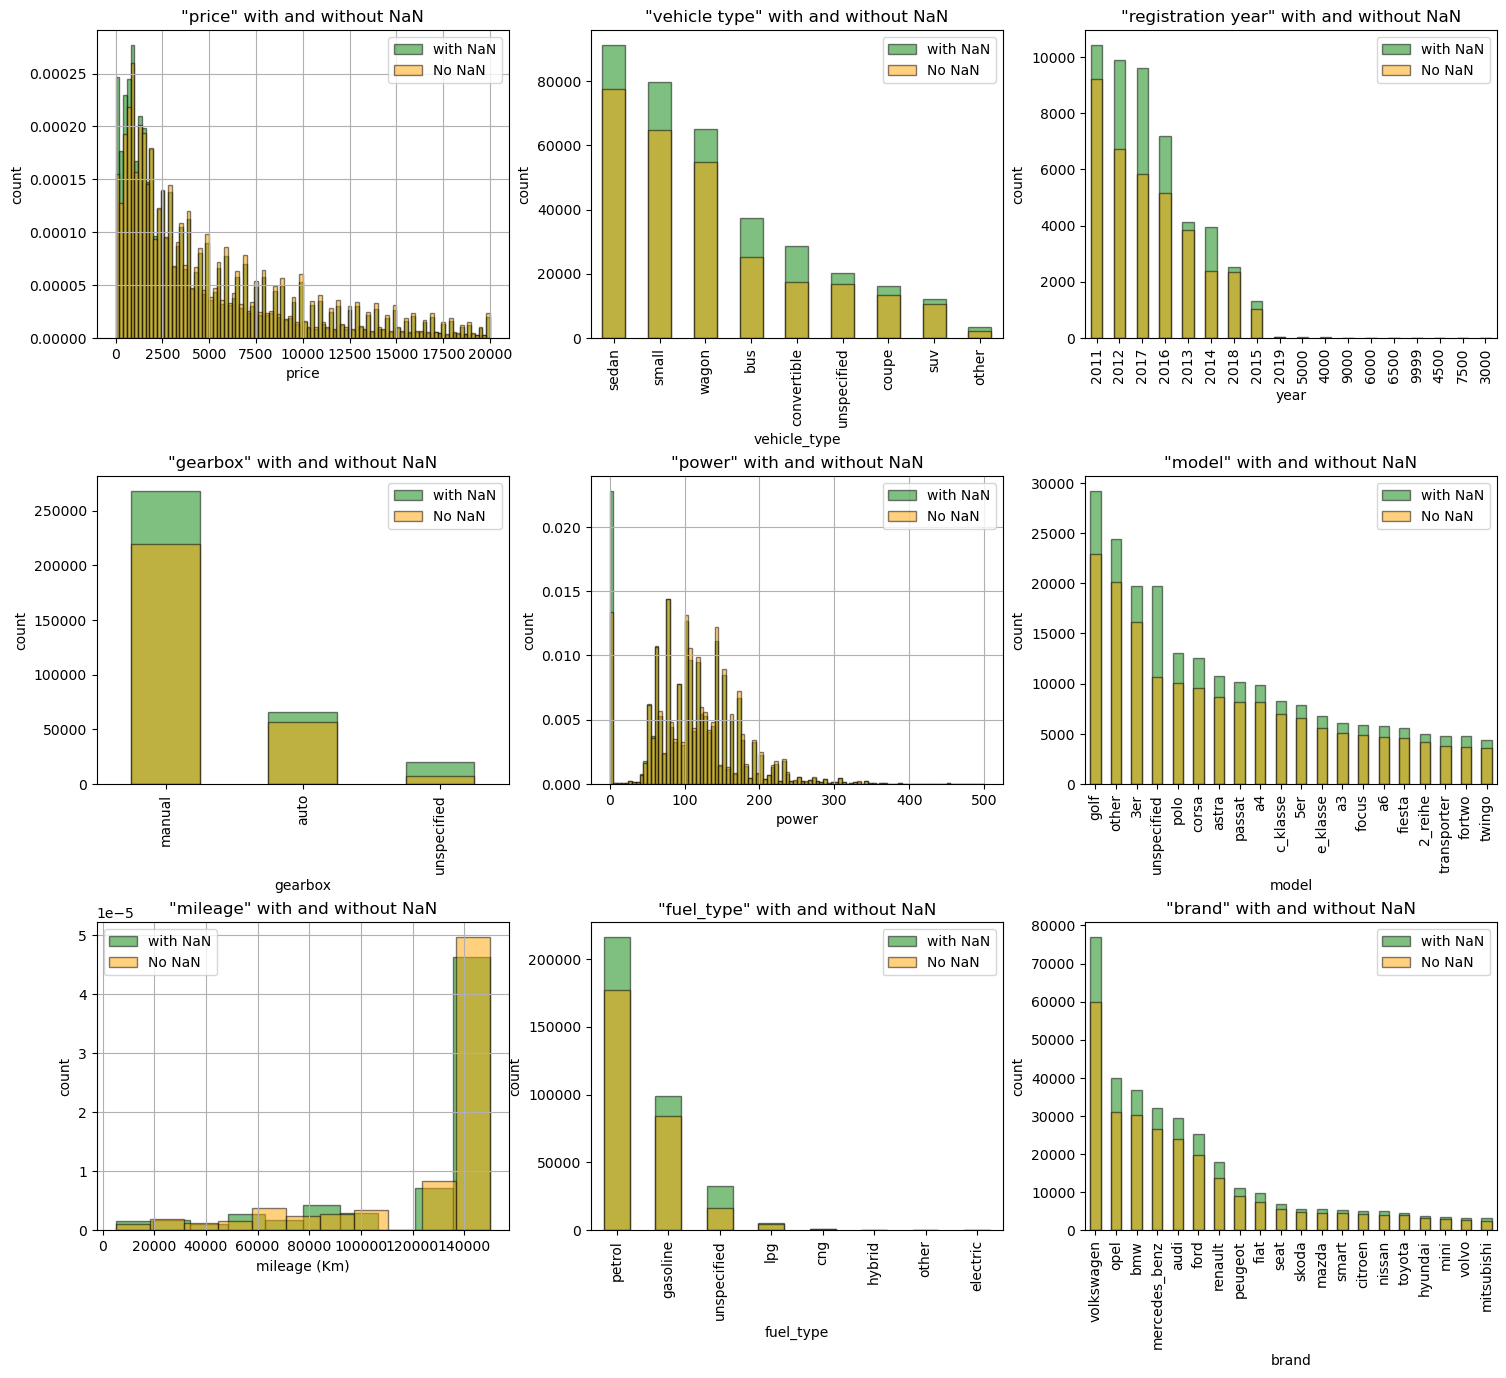

In [25]:
# Plots to review the distributions on complete data with NaN and data without NaN.

fig, ((a,b,c),(d,e,f),(g,h,i))= plt.subplots(figsize=(16,15), nrows=3, ncols=3)

# Gráfico 1
df['price'].hist(       ax=a, edgecolor='black', color='green', alpha=0.5, density=True, label='with NaN', bins=100)
df_no_nan['price'].hist(ax=a, edgecolor='black', color='orange', alpha=0.5, density=True, label='No NaN', bins=100)
a.legend()
a.set_xlabel('price')
a.set_ylabel('count')
a.set_title('"price" with and without NaN')

# Gráfico 2
df['vehicle_type'].value_counts().plot(       ax=b, kind='bar', edgecolor='black', color='green', alpha=0.5, label='with NaN')
df_no_nan['vehicle_type'].value_counts().plot(ax=b, kind='bar', edgecolor='black', color='orange', alpha=0.5, label='No NaN')
b.legend()
b.set_xlabel('vehicle_type')
b.set_ylabel('count')
b.set_title('"vehicle type" with and without NaN')

# Gráfico 3
condition_1 = 'registration_year > 2010 and registration_year <= 20016'
df.query(condition_1)['registration_year'].value_counts().plot(       ax=c, kind='bar', edgecolor='black', color='green', alpha=0.5, label='with NaN')
df_no_nan.query(condition_1)['registration_year'].value_counts().plot(ax=c, kind='bar', edgecolor='black', color='orange', alpha=0.5, label='No NaN')
c.legend()
c.set_xlabel('year')
c.set_ylabel('count')
c.set_title('"registration year" with and without NaN')

# Gráfico 4
df['gearbox'].value_counts().plot(       ax=d, kind='bar', edgecolor='black', color='green', alpha=0.5, label='with NaN')
df_no_nan['gearbox'].value_counts().plot(ax=d, kind='bar', edgecolor='black', color='orange', alpha=0.5, label='No NaN')
d.legend()
d.set_xlabel('gearbox')
d.set_ylabel('count')
d.set_title('"gearbox" with and without NaN')

# Gráfico 5
df['power'].hist(       ax=e, bins=100, edgecolor='black', color='green', alpha=0.5, density=True, label='with NaN', range=(0,500))
df_no_nan['power'].hist(ax=e, bins=100, edgecolor='black', color='orange', alpha=0.5, density=True, label='No NaN', range=(0,500) )
e.legend()
e.set_xlabel('power')
e.set_ylabel('count')
e.set_title('"power" with and without NaN')

# Gráfico 6
df['model'].value_counts().sort_values(ascending=False).head(20).plot(       ax=f, edgecolor='black', kind='bar', color='green', alpha=0.5, label='with NaN')
df_no_nan['model'].value_counts().sort_values(ascending=False).head(20).plot(ax=f, edgecolor='black', kind='bar', color='orange', alpha=0.5, label='No NaN')
f.legend()
f.set_xlabel('model')
f.set_ylabel('count')
f.set_title('"model" with and without NaN')

# Gráfico 7
df['mileage'].hist(       ax=g, edgecolor='black', color='green', alpha=0.5, density=True, label='with NaN', bins=10)
df_no_nan['mileage'].hist(ax=g, edgecolor='black', color='orange', alpha=0.5, density=True, label='No NaN', bins=11)
g.legend()
g.set_xlabel('mileage (Km)')
g.set_ylabel('count')
g.set_title('"mileage" with and without NaN')

# Gráfico 8
df['fuel_type'].value_counts().plot(       ax=h, kind='bar', edgecolor='black', color='green', alpha=0.5, label='with NaN')
df_no_nan['fuel_type'].value_counts().plot(ax=h, kind='bar', edgecolor='black', color='orange', alpha=0.5, label='No NaN')
h.legend()
h.set_xlabel('fuel_type')
h.set_ylabel('count')
h.set_title('"fuel_type" with and without NaN')

# Gráfico 9
df['brand'].value_counts().sort_values(ascending=False).head(20).plot(       ax=i, kind='bar', edgecolor='black', color='green', alpha=0.5, label='with NaN')
df_no_nan['brand'].value_counts().sort_values(ascending=False).head(20).plot(ax=i, kind='bar', edgecolor='black', color='orange', alpha=0.5, label='No NaN')
i.legend()
i.set_xlabel('brand')
i.set_ylabel('count')
i.set_title('"brand" with and without NaN')

# Ajustes
plt.subplots_adjust(left=0.125,
                    bottom=0.2, 
                    right=1, 
                    top=1, 
                    wspace=0.2, 
                    hspace=0.45)

plt.show()

Hemos podido revisar como se encuentran distribuidos los datos en cada característica desde el dataset total y el dataset sin registros NaN en la columna 'no_repaired', demostrando que los datos no cambian su distribución, por lo que procedemos a remover los registros que contienen NaN en `not_repaired`.

In [26]:
# Remove NaN in column not_repaired
df = df.dropna(subset=['not_repaired'])
df = df.reset_index(drop=True)

In [27]:
# Change data type bool, yes = True, no = False
df['not_repaired'] = df['not_repaired'] == 'yes'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282962 entries, 0 to 282961
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   price              282962 non-null  int64         
 1   vehicle_type       282962 non-null  object        
 2   registration_year  282962 non-null  int64         
 3   gearbox            282962 non-null  object        
 4   power              282962 non-null  int64         
 5   model              282962 non-null  object        
 6   mileage            282962 non-null  int64         
 7   fuel_type          282962 non-null  object        
 8   brand              282962 non-null  object        
 9   not_repaired       282962 non-null  bool          
 10  date_created       282962 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), int64(4), object(5)
memory usage: 21.9+ MB


In [28]:
df.shape

(282962, 11)

In [29]:
# Check NaN
df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
mileage              0
fuel_type            0
brand                0
not_repaired         0
date_created         0
dtype: int64

Nuestro dataset está limpio de valores ausentes.

# Análisis exploratorio de datos

Vamos a explorar nuestros datos:

### Tipo de vehículo

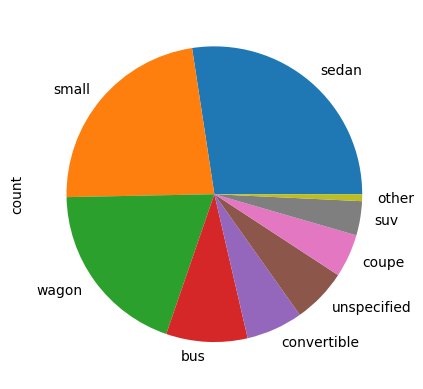

In [30]:
df.vehicle_type.value_counts().plot(kind='pie')
plt.show()

Predominan 3 tipos de carros, sedan, wagon y small.

### Año de registro

Describe el año de matricula del vehículo. Con esta información podremos determinar un periodo válido de los años de matriculación de vehículo, por ejemplo un periodo de 20 años.

In [31]:
df.registration_year.sort_values().unique()

array([1000, 1234, 1500, 1600, 1602, 1800, 1910, 1919, 1923, 1925, 1929,
       1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941,
       1942, 1943, 1944, 1945, 1947, 1948, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 3000,
       4000, 4500, 5000, 6000, 6500, 7500, 9000, 9999], dtype=int64)

In [32]:
df.registration_year.value_counts().head(20)

registration_year
1999    17854
2005    17642
2006    17597
2000    17191
2003    16665
2004    16605
2001    16491
2002    15917
2007    15349
2008    13933
1998    13815
2009    13260
1997    11087
2010     9871
2011     9213
1996     8077
2012     6716
1995     6275
2017     5847
2016     5172
Name: count, dtype: int64

Encontramos vehículos con registros desde el año 1000 hasta el 9999, no tiene sentido tener registros debajo de los años 90 y por encima del 2016, siendo el 2016 el año máximo, puesto que esta base de datos fue extraida en el año 2016. Dicho esto es muy prudente considerar nuestro dataset en un periodo de 20 años, desde 1996 hasta el 2016.

In [33]:
# Check 
df.query('registration_year < 1996 or registration_year > 2016')

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired,date_created
3,650,sedan,1995,manual,102,3er,150000,petrol,bmw,True,2016-04-04
5,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,False,2016-03-21
15,2900,unspecified,2018,manual,90,meriva,150000,petrol,opel,False,2016-03-23
17,500,sedan,1990,manual,118,other,150000,petrol,mercedes_benz,True,2016-03-13
19,5555,unspecified,2017,manual,125,c4,125000,unspecified,citroen,False,2016-03-10
...,...,...,...,...,...,...,...,...,...,...,...
282905,5000,unspecified,2017,manual,120,other,150000,unspecified,citroen,True,2016-03-05
282914,850,sedan,1989,manual,113,80,150000,petrol,audi,True,2016-03-05
282922,1550,small,1990,manual,54,golf,150000,petrol,volkswagen,False,2016-04-04
282925,3300,coupe,1957,manual,40,other,100000,petrol,trabant,False,2016-03-07


In [34]:
# Percentage of cars registered outside the period of years 1996-2016
print('%', round(len(df.query('registration_year < 1996 or registration_year > 2016')) / len(df) * 100))

% 12


El 12% de los registros están fuera del periodo 1996 - 2016.

In [35]:
# Filter year 1996 - 2016
df = df.query('registration_year >= 1996 and registration_year <= 2016')
df = df.reset_index(drop=True)

In [36]:
df.shape

(249719, 11)

Veamos gráficamente los vehículos distribuidos según el año de matriculación (periodo 1996 - 2016)

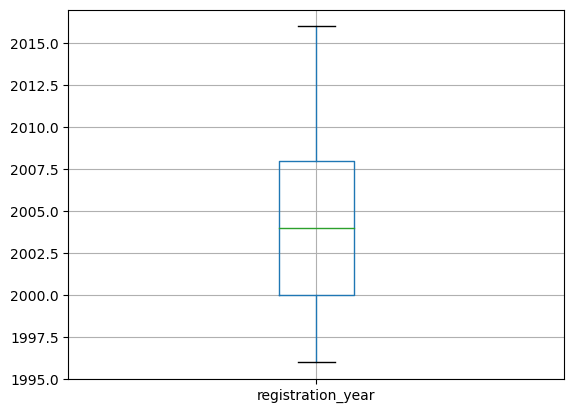

In [37]:
df[['registration_year']].boxplot()
plt.show()

### Kilometraje
Revisaremos la información sobre el kilometraje del vehículo

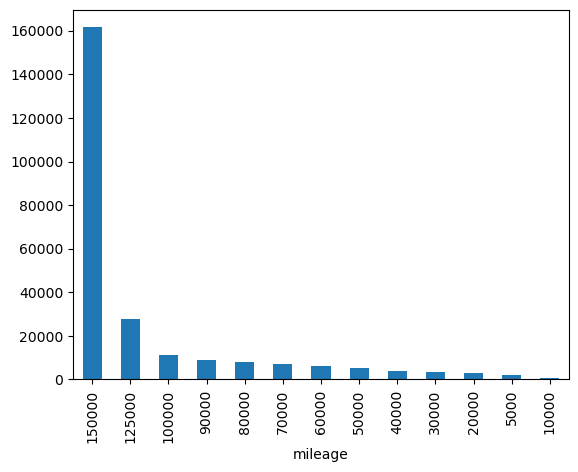

In [38]:
df.mileage.value_counts().plot(kind='bar')
plt.show()

La mayor parte de los vehículos que están en venta tienen un kilometraje por encima de los 125.000 km.

### Potencia

In [39]:
df['power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    22,    23,    24,    25,    26,    29,
          30,    31,    32,    33,    34,    35,    36,    37,    38,
          39,    40,    41,    42,    43,    44,    45,    46,    47,
          48,    49,    50,    51,    52,    53,    54,    55,    56,
          57,    58,    59,    60,    61,    62,    63,    64,    65,
          66,    67,    68,    69,    70,    71,    72,    73,    74,
          75,    76,    77,    78,    79,    80,    81,    82,    83,
          84,    85,    86,    87,    88,    89,    90,    91,    92,
          93,    94,    95,    96,    97,    98,    99,   100,   101,
         102,   103,   104,   105,   106,   107,   108,   109,   110,
         111,   112,   113,   114,   115,   116,   117,   118,   119,
         120,   121,   122,   123,   124,   125,   126,   127,   128,
         129,   130,

Existen vehiculos con potencias desde 0 hasta 2000. Grafiquemos esta distribución, e identifiquemos outliers.

<Axes: >

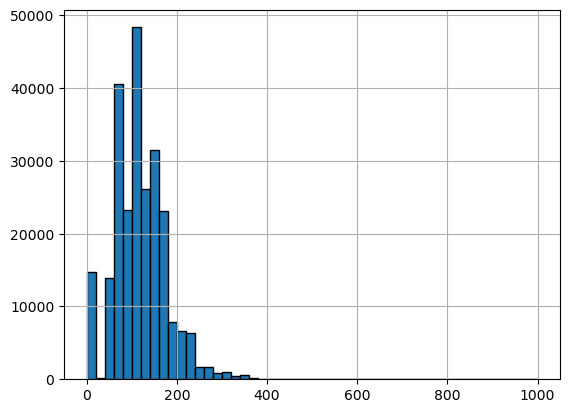

In [40]:
df['power'].hist(bins=50, range=(0,1000), edgecolor='black')

In [41]:
df.query('power <= 10')

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired,date_created
20,1500,unspecified,2016,unspecified,0,kangoo,150000,gasoline,renault,False,2016-03-28
27,4700,wagon,2005,manual,0,signum,150000,unspecified,opel,False,2016-03-17
28,550,wagon,1999,manual,0,astra,150000,gasoline,opel,True,2016-03-26
56,4290,bus,2008,manual,0,combo,150000,gasoline,opel,False,2016-03-11
73,8000,unspecified,2009,manual,0,golf,100000,petrol,volkswagen,False,2016-03-20
...,...,...,...,...,...,...,...,...,...,...,...
249692,7900,bus,2007,manual,0,b_klasse,125000,petrol,mercedes_benz,False,2016-03-13
249695,390,small,1997,auto,0,corsa,100000,petrol,opel,True,2016-04-04
249712,3999,wagon,2005,manual,3,3er,150000,gasoline,bmw,False,2016-04-02
249715,1150,bus,2000,manual,0,zafira,150000,petrol,opel,False,2016-03-27


In [42]:
df.power.value_counts(normalize=True)

power
75      0.065906
0       0.058278
60      0.043581
150     0.043161
140     0.043144
          ...   
519     0.000004
585     0.000004
6006    0.000004
5815    0.000004
1241    0.000004
Name: proportion, Length: 573, dtype: float64

Observamos que el 5,8% de registros tiene power=0, estos deben ser eliminados.

In [43]:
len(df)

249719

In [44]:
# Remove power = 0
df = df.drop(df[df.power == 0].index)
df = df.reset_index(drop=True)
df.shape

(235166, 11)

Vemos que los datos en power tienen un sesgo a la derecha, es decir valores muy grandes con una frecuencia baja. A continuacion buscaremos y eliminaremos outliers de ser el caso.

In [45]:
# funtion clean_outliers
def clean_outliers(df, col):

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    min = (Q1 - 1.5 * IQR).astype('int')
    max = (Q3 + 1.5 * IQR).astype('int')

    indexes = df[(df[col] <= min) | (df[col] >= max)].index
    df = df.drop(indexes)
    return df

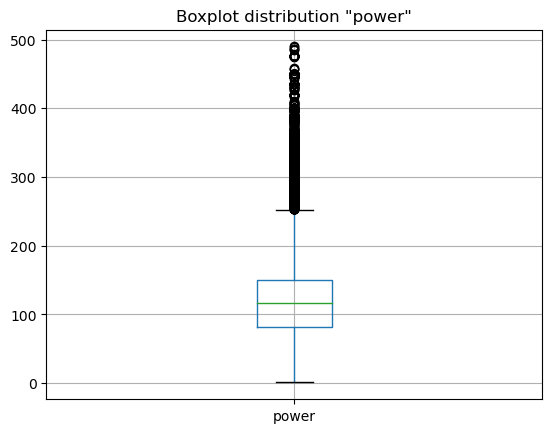

In [46]:
df[['power']].query('power < 500').boxplot()
plt.title('Boxplot distribution "power"')
plt.show()

In [47]:
len(df)

235166

In [48]:
# Clean outliers in "power"
total = len(df)
df = clean_outliers(df, 'power')
df = df.reset_index(drop=True)

percent = (total - len(df)) / total
print(f'removed outliers {percent:.2%} \n')

removed outliers 2.46% 



In [49]:
len(df)

229390

Visualizamos los datos de "power" después de eliminar el 2.46% de registros outliers.

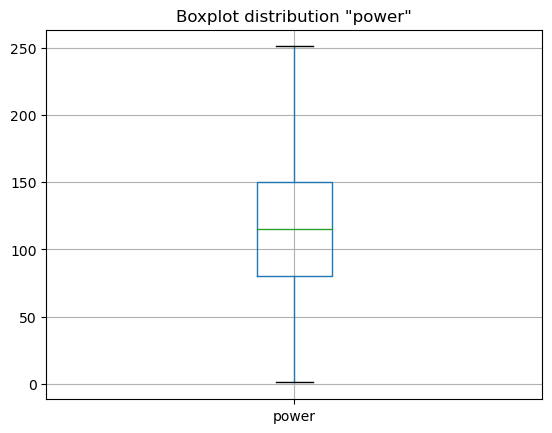

In [50]:
df[['power']].boxplot()
plt.title('Boxplot distribution "power"')
plt.show()

Nuestro dataset queda saneado con valores mayores a 0 y menos a 250 en la columna "power".

### Marca

Text(0.5, 1.0, 'Top 10 brand car')

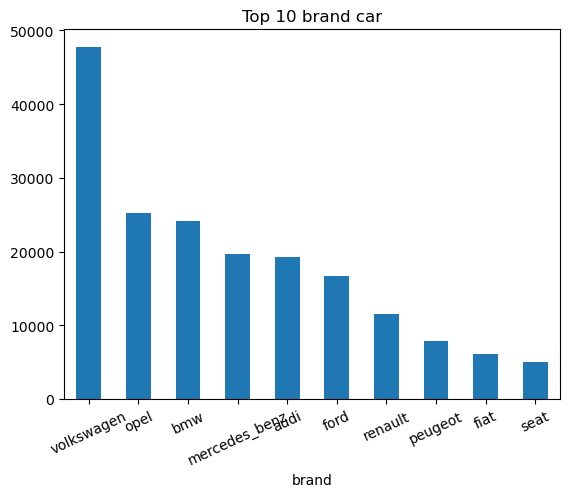

In [51]:
df.brand.value_counts(ascending=False).head(10).plot(kind='bar', rot=25)
plt.title('Top 10 brand car')

### Precio

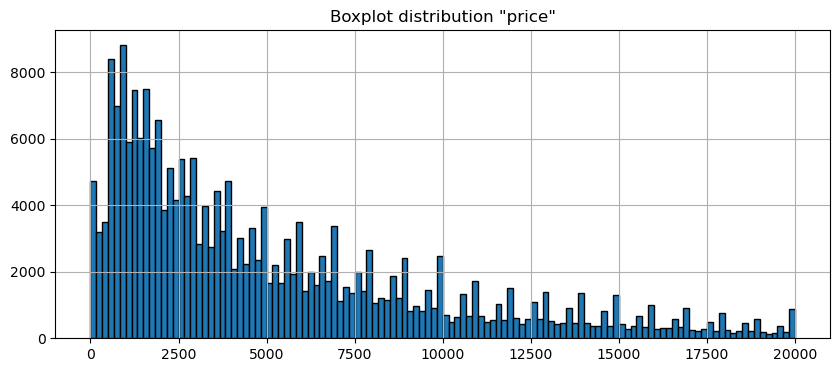

In [52]:
df.price.hist(bins=120, edgecolor='black', figsize=(10,4))
plt.title('Boxplot distribution "price"')
plt.show()

Podemos observar en el histograma una distribución con una asimetría positiva, los vehículos más se ponen en venta están por debajo de 3000 euros, y entre mayor es precio menor la frecuencia de venta, podemos observar vehículos hasta en 20.000 euros. También podemos observar vehículos que valen menos que 100 euros.

In [53]:
print(round(len(df.query('price < 100')) / len(df),2))

0.02


El valor mínimo que se pone en venta un vehículo deberá estar validado en la app de venta de carros, sin embargo para fines de este estudio podríamos establecer como valor mínimo de venta de 100 euros. Por lo que tomaremos los valores menores a 100 y los removeremos de nuestro dataset, estos representan el 2% de los datos

In [54]:
df.shape

(229390, 11)

In [55]:
# Remove price < 100 euros
df = df.drop(df[df.price < 100].index)
df = df.reset_index(drop=True)
df.shape

(225605, 11)

Ok, hemos eliminado los registros con precios menores a 100 euros. Nuestro dataset ha disminuido un 2%.

### Correlaciones

Revisemos la interdependencia del precio con respecto a otras características, mediante la correlación:

In [56]:
df[['price','registration_year','power','mileage']].corr()

,price,registration_year,power,mileage
price,1.000000,0.672759,0.495534,-0.425847
registration_year,0.672759,1.000000,0.139703,-0.483183
power,0.495534,0.139703,1.000000,0.122896
mileage,-0.425847,-0.483183,0.122896,1.000000


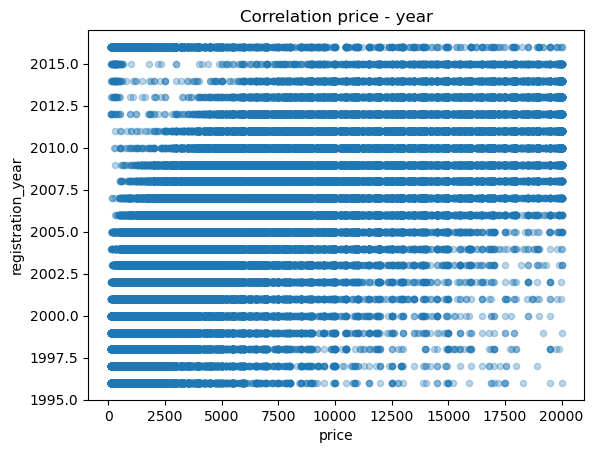

In [57]:
df.plot(x='price', y='registration_year', kind='scatter', alpha=0.3) 
plt.title('Correlation price - year')
plt.show()

Observamos la correlacion entre precio y varias características del vehículo. Podemos ver que hay conexiones muy débiles ya que son cercanas a cero, y conexiones medianamente fuerte price con registration_year con un 0.67 de correlación.

# Procesamiento de datos

### Escalado de datos
Antes de empezar a entrenar nuestro modelo vamos a aplicar un escalado en los datos con la estandarización de datos usando `StandardScaler` a las siguientes columnas numéricas:

In [58]:
# Copy dataframe df to df_scaler
df_scaler = df.copy()

In [59]:
# Numerical feature scaling
numeric = ['registration_year', 'power', 'mileage']

scaler = StandardScaler()
scaler.fit(df_scaler[numeric])

df_scaler[numeric] = scaler.transform(df_scaler[numeric])

In [60]:
df_scaler.head()

,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired,date_created
0,18300,coupe,1.390021,manual,1.555349,unspecified,-0.042657,gasoline,audi,True,2016-03-24
1,1500,small,-0.680925,manual,-0.964598,golf,0.626120,petrol,volkswagen,False,2016-03-17
2,3600,small,0.768737,manual,-1.096073,fabia,-0.978945,gasoline,skoda,False,2016-03-31
3,2200,convertible,-0.059641,manual,-0.219570,2_reihe,0.626120,petrol,peugeot,False,2016-04-01
4,2000,sedan,-0.059641,manual,-0.307220,3_reihe,0.626120,petrol,mazda,False,2016-03-26


### Codificar características categóricas
Realizaremos codificacion de variables categóricas usando *One-Hot Encoding*. Las columnas categóricas a las que se aplicará la codificación son las siguientes: 'vehicle_type', 'gearbox', 'model', 'fuel_type', y 'brand'. 

Primero identificamos las características y objetivo: `features`, `target`

In [61]:
# identify characteristics and target
features = df_scaler.drop(['price','date_created'], axis=1)
target   = df_scaler['price']

Guardamos nuestras características con codificación One-Hot en: `features_ohe`.

In [62]:
# Encode categorical features with One-Hot encoding
features_ohe = pd.get_dummies(data = features, 
                              columns=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand'], 
                              drop_first=True)

In [63]:
features.shape, features_ohe.shape

((225605, 9), (225605, 304))

Podemos ver el tamaño de nuestras características con y sin One-Hot, las que se le aplicó la codificación aumentaron considerablemente el número de columnas, con razón puesto que teníamos mucha variedad en la marca y el modelo del vehículo.

Segmentamos nuestro dataset en datos para entrenamiento, validación y test, proporción: 4:2:2

In [64]:
X_train, X_valid, X_train_ohe, X_valid_ohe, y_train, y_valid = train_test_split(features, features_ohe, target, test_size=0.40, random_state=12345)
X_valid, X_test,  X_valid_ohe, X_test_ohe,  y_valid, y_test  = train_test_split(X_valid,  X_valid_ohe, y_valid, test_size=0.50, random_state=12345)

In [65]:
print('Size')
print(f'- data train: features{X_train.shape},features ohe: {X_train_ohe.shape},target{y_train.shape}')
print(f'- data valid: features{X_valid.shape}, features ohe: {X_valid_ohe.shape}, target{y_valid.shape}')
print(f'- data test:  features{X_test.shape}, features ohe: {X_test_ohe.shape}, target{y_test.shape}')

Size
- data train: features(135363, 9),features ohe: (135363, 304),target(135363,)
- data valid: features(45121, 9), features ohe: (45121, 304), target(45121,)
- data test:  features(45121, 9), features ohe: (45121, 304), target(45121,)


# Entrenamiento del modelo 

Vamos a entrenar varios modelos para predecir el precio de un vehículo. Buscaremos el mejor con el menor error usando la métrica RMSE para evaluar la calidad de los modelos. Además revisaremos la velocidad de predicción y el tiempo para el entrenamiento. Nuestros modelos probarán técnicas de potenciación de gradiente, y un modelo basado en árboles, todos ajustando hiperparámetros. Además, realizaremos una prueba de cordura, para ella realizaremos un modelo usando regresión lineal.

In [66]:
# Create a data frame named "summary_models" where we will save information about our different models
summary_models = pd.DataFrame(columns=['model', 'score_rmse', 'training_time_sec', 'prediction_speed_sec'])

## Modelo base con Regresión lineal
Entrenaremos un modelo de regresión lineal como prueba de cordura para el mejor modelo que entrenemos.

In [67]:
# Linear Regression
model_lr = LinearRegression()
start_time = time.time()
model_lr.fit(X_train_ohe, y_train)
train_time = time.time() - start_time

# Prediction valid data
start_time = time.time()
y_predict = model_lr.predict(X_valid_ohe)
pred_time = time.time() - start_time

# Metric
rmse = mean_squared_error(y_valid, y_predict, squared=False) 
print('Model Linear regression')

# Print the times of train and predict
print("RMSE= {:.2f},    time train: {:.2f}s,    time prediction: {:.2f}s".format(rmse, train_time, pred_time))

# Save info
summary_models.loc['LinearRegression'] = {'model': model_lr, 
                                          'score_rmse': rmse, 
                                          'training_time_sec':train_time, 
                                          'prediction_speed_sec':pred_time}

Model Linear regression
RMSE= 2149.98,    time train: 2.54s,    time prediction: 0.08s


Nuestro modelo base con Regresion Lineal, tiene un `RMSE` 2149, es bastate alto. Por lo que el modelo que vamos a entrenar debe ser mejor que este, debemos minimizar este error.

## Modelo Bosque Aleatorio

In [68]:
# Adjusting hyperparameters to Randon Forest:

print('Random Forest Regressor, adjusting hyperparameters:')

best_score = float('inf')
for tree in range(4, 11, 2):
    for depth in range(4, 17, 4):
        model_rf = RandomForestRegressor(random_state = 12345, 
                                         n_estimators = tree, 
                                         max_depth = depth)

        # Training
        model_rf.fit(X_train_ohe, y_train)

        # predicción para datos de valiación
        y_pred = model_rf.predict(X_valid_ohe)

        # Metric
        rmse = mean_squared_error(y_valid, y_pred, squared=False) 
        print("RMSE= {:.2f},    tree: {},    max_depth: {}".format(rmse, tree, depth))

        if rmse < best_score:
            best_score = rmse
            best_model = model_rf

print(f'\nBest RMSE {best_score}')
display(best_model)

Random Forest Regressor, adjusting hyperparameters:
RMSE= 2402.08,    tree: 4,    max_depth: 4
RMSE= 1921.40,    tree: 4,    max_depth: 8
RMSE= 1681.73,    tree: 4,    max_depth: 12
RMSE= 1566.12,    tree: 4,    max_depth: 16
RMSE= 2407.96,    tree: 6,    max_depth: 4
RMSE= 1912.09,    tree: 6,    max_depth: 8
RMSE= 1671.76,    tree: 6,    max_depth: 12
RMSE= 1551.47,    tree: 6,    max_depth: 16
RMSE= 2405.59,    tree: 8,    max_depth: 4
RMSE= 1908.77,    tree: 8,    max_depth: 8
RMSE= 1666.35,    tree: 8,    max_depth: 12
RMSE= 1542.55,    tree: 8,    max_depth: 16
RMSE= 2411.84,    tree: 10,    max_depth: 4
RMSE= 1910.24,    tree: 10,    max_depth: 8
RMSE= 1664.78,    tree: 10,    max_depth: 12
RMSE= 1539.97,    tree: 10,    max_depth: 16

Best RMSE 1539.9743616298827


RandomForestRegressor(max_depth=16, n_estimators=10, random_state=12345)

Como vemos, hemos obtenido nuestros mejores hiperparámetros. A continuación realizaremos el entrenamiento final de este modelo RandomForest.

In [69]:
# Random Forest Regressor:

print('Model Random Forest Regressor')

model_rf = RandomForestRegressor(random_state=12345, 
                                 n_estimators=10, 
                                 max_depth=16)

# Training
start_time = time.time()
model_rf.fit(X_train_ohe, y_train)
train_time = time.time() - start_time

# Predict
start_time = time.time()
y_pred = model_rf.predict(X_valid_ohe)
pred_time = time.time() - start_time

# Metric
rmse = mean_squared_error(y_valid, y_pred, squared=False) 

print("RMSE= {:.2f},    time train: {:.2f}s,    time prediction: {:.2f}s".format(rmse, train_time, pred_time))

# Save info
summary_models.loc['RandomForestRegressor'] = {'model': model_rf, 
                                               'score_rmse': rmse, 
                                               'training_time_sec':train_time, 
                                               'prediction_speed_sec':pred_time}

Model Random Forest Regressor
RMSE= 1539.97,    time train: 15.29s,    time prediction: 0.11s


Nuestro modelo RandomForestRegressor obtuvo un `RMSE` 1539 mejor que nuestro modelo base.

## Modelos con potenciación de gradiente (Gradient boosting)

### Modelo CatBoostRegressor

Entrenaremos un modelo con CatBoostRegressor; este está basado en árboles de decisión. Realizaremos un ajuste de hiperparámetros con GridSearchCV, donde variaremos la profundidad del árbol, tasa de aprendizaje y el número de iteraciones.

Además usaremos nuestras características sin codificación ohe `X_train, X_valid`, ya que CatBoost aplica internamente técnicas de codificación para características categóricas.

In [70]:
# Adjusting hyperparameters to CatBoostRegressor with GridSearchCV

parameters = {'depth': [4, 6, 8],
              'iterations': [10, 100, 200],
              'learning_rate': [0.4, 0.2]
              }

grid_search = GridSearchCV(estimator = CatBoostRegressor(), 
                           param_grid = parameters, 
                           cv = 3, 
                           scoring = 'neg_mean_squared_error')

cat_features = ['vehicle_type','gearbox','model','fuel_type','brand']

start_time = time.time()
grid_search.fit(X_train, y_train, cat_features=cat_features, verbose=100)
train_time = time.time() - start_time

# Best model and best parameters
best_model_cb = grid_search.best_estimator_
best_parameters  = grid_search.best_params_

print(best_parameters)
print(np.sqrt(-grid_search.best_score_))

0:	learn: 3539.6593718	total: 171ms	remaining: 1.53s
9:	learn: 1903.8110332	total: 350ms	remaining: 0us
0:	learn: 3549.9211421	total: 23.1ms	remaining: 208ms
9:	learn: 1907.6558277	total: 193ms	remaining: 0us
0:	learn: 3535.9414445	total: 18.8ms	remaining: 169ms
9:	learn: 1883.6858118	total: 183ms	remaining: 0us
0:	learn: 4038.0953836	total: 21.8ms	remaining: 196ms
9:	learn: 2227.2652321	total: 185ms	remaining: 0us
0:	learn: 4049.9920566	total: 18.7ms	remaining: 169ms
9:	learn: 2220.3933193	total: 181ms	remaining: 0us
0:	learn: 4037.4381234	total: 19.3ms	remaining: 174ms
9:	learn: 2216.5329960	total: 189ms	remaining: 0us
0:	learn: 3539.6593718	total: 19.2ms	remaining: 1.9s
99:	learn: 1605.6061474	total: 1.77s	remaining: 0us
0:	learn: 3549.9211421	total: 19.6ms	remaining: 1.94s
99:	learn: 1585.5350443	total: 1.83s	remaining: 0us
0:	learn: 3535.9414445	total: 19.8ms	remaining: 1.96s
99:	learn: 1586.9943518	total: 1.86s	remaining: 0us
0:	learn: 4038.0953836	total: 18.7ms	remaining: 1.85s


Como vemos, hemos obtenido nuestros mejores hiperparámetros. A continuación realizaremos el entrenamiento final de este modelo CatBoostRegressor.

In [71]:
# Model CatBoostRegressor

cat_features = ['vehicle_type','gearbox','model','fuel_type','brand']

# Training
start_time = time.time()
best_model_cb.fit(X_train, y_train, cat_features=cat_features, verbose=100)
train_time = time.time() - start_time

# Predict 
start_time = time.time()
y_predicts = best_model_cb.predict(X_valid)
pred_time = time.time() - start_time

# Metric
rmse = mean_squared_error(y_valid, y_predicts, squared=False)
print("\nRMSE= {:.2f},    time train: {:.2f}s,    time prediction: {:.2f}s".format(rmse, train_time, pred_time))

# Save info
summary_models.loc['CatBoostRegressor'] = {'model': best_model_cb, 
                                           'score_rmse': rmse, 
                                           'training_time_sec':train_time, 
                                           'prediction_speed_sec':pred_time}

0:	learn: 3375.8998631	total: 81.5ms	remaining: 16.2s
100:	learn: 1405.3414524	total: 6.8s	remaining: 6.67s
199:	learn: 1341.3760612	total: 13.8s	remaining: 0us

RMSE= 1441.32,    time train: 14.16s,    time prediction: 0.10s


Nuestro modelo con CatBoostRegressor tuvo un `RMSE` 1441, hasta el momento el mejor modelo. Sigamos entrenando un par de modelos más.

### Modelo XGBRegressor

Continuamos probando otro modelo con XGBXGBRegressor, también usa potenciación de gradiente. Usaremos nuestras características a las cuales aplicamos la codificación One-Hot `X_train_ohe`, `X_valid_ohe`.

In [72]:
# Adjusting hyperparameters to XGBRegressor with GridSearchCV

parameters = {'max_depth': [4, 6, 8],
              'n_estimators': [10, 100, 200],
              'learning_rate': [0.4, 0.2]}

grid_search = GridSearchCV(estimator = XGBRegressor(), 
                           param_grid = parameters, 
                           cv = 2, 
                           scoring = 'neg_mean_squared_error')

grid_search.fit(X_train_ohe, y_train, verbose=100) 

# Best model and best parameters 
best_model_xgb = grid_search.best_estimator_
best_parameters = grid_search.best_params_

print(best_parameters)
print(np.sqrt(-grid_search.best_score_))

{'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200}
1478.5046497864537


Como vemos, hemos obtenido nuestros mejores hiperparámetros. A continuación realizaremos el entrenamiento final de este modelo XGBRegressor.

In [73]:
#  Model XGBRegressor

# Training
start_time = time.time()
best_model_xgb.fit(X_train_ohe, y_train)
train_time = time.time() - start_time

# Predict
start_time = time.time()
y_predict = best_model_xgb.predict(X_valid_ohe)
pred_time = time.time() - start_time

# Metric 
rmse = mean_squared_error(y_valid, y_predict, squared=False)
print("\nRMSE= {:.2f},    time train: {:.2f}s,    time prediction: {:.2f}s".format(rmse, train_time, pred_time))

# Save info
summary_models.loc['XGBRegressor'] = {'model': best_model_xgb, 
                                      'score_rmse': rmse, 
                                      'training_time_sec':train_time, 
                                      'prediction_speed_sec':pred_time}


RMSE= 1431.13,    time train: 47.22s,    time prediction: 0.62s


Como vemos, hemos obtenido nuestros mejores hiperparámetros. A continuación realizaremos el entrenamiento final de este modelo CatBoostRegressor.

### Modelo LGBMRegressor
LGBMRegressor es también un modelo con potenciación de gradiente y funciona directamente con características categóricas al igual que CatBoost.

Antes del entrenamiento, vamos a cambiar el tipo de datos de nuestras variables categóricas, al tipo `category`.

In [74]:
# Change categorical feature  "object" to "category"
cat_features = ['vehicle_type','gearbox','model','fuel_type','brand']

for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')

In [75]:
# Adjusting hyperparameters to LGBMRegressor with GridSearchCV

parameters = {'max_depth':  [4, 6, 8],
              'n_estimators': [10, 100, 200],
              'learning_rate': [0.4, 0.2]}

grid_search = GridSearchCV(estimator = LGBMRegressor(), 
                           param_grid = parameters, 
                           scoring='neg_mean_squared_error', 
                           cv=3)

grid_search.fit(X_train, y_train)

# Best model y parameters 
best_model_lgbm = grid_search.best_estimator_
best_parameters = grid_search.best_params_

print(best_parameters)
print(np.sqrt(-grid_search.best_score_))

{'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200}
1451.8387235779196


Como vemos, hemos obtenido nuestros mejores hiperparámetros. A continuación realizaremos el entrenamiento final de este modelo CatBoostRegressor.

In [76]:
#  Model LGBMRegressor
best_model_lgbm = LGBMRegressor(max_depth = 10,
                         n_estimators = 12,
                         learning_rate = 0.5)

# Entrenamos el modelo en el conjunto de entrenamiento
start_time = time.time()
best_model_lgbm.fit(X_train, y_train)
train_time = time.time() - start_time

# Realizamos predicciones en el conjunto de prueba
start_time = time.time()
y_predict = best_model_lgbm.predict(X_valid)
pred_time = time.time() - start_time

# Medimos la precisión del modelo en el conjunto de prueba utilizando el RMSE
rmse = mean_squared_error(y_valid, y_predict, squared=False)

# Print
print("\nRMSE= {:.2f},    time train: {:.2f}s,    time prediction: {:.2f}s".format(rmse, train_time, pred_time))

# Save info
summary_models.loc['LGBMRegressor'] = {'model': best_model_lgbm, 
                                      'score_rmse': rmse, 
                                      'training_time_sec':train_time, 
                                      'prediction_speed_sec':pred_time}


RMSE= 1579.44,    time train: 0.14s,    time prediction: 0.03s


## Análisis del modelo

Revisemos un resumen de nuestros mejores modelos. Nos interesa saber:
- la calidad de la predicción
- la velocidad de la predicción
- el tiempo requerido para el entrenamiento


In [77]:
summary_models

,model,score_rmse,training_time_sec,prediction_speed_sec
LinearRegression,LinearRegression(),2149.977537,2.537752,0.077259
RandomForestRegressor,"(DecisionTreeRegressor(max_depth=16, max_featu...",1539.974362,15.293413,0.109743
CatBoostRegressor,<catboost.core.CatBoostRegressor object at 0x0...,1441.316760,14.156814,0.101458
XGBRegressor,"XGBRegressor(base_score=None, booster=None, ca...",1431.128795,47.222970,0.617821
LGBMRegressor,"LGBMRegressor(learning_rate=0.5, max_depth=10,...",1579.438238,0.141744,0.030173


Podemos observar en resumen el entrenamiento de nuestros modelos a los cuales pudimos evaluar la calidad, tiempo de entrenamiento y tiempo de predicción. Obteniendo las siguientes conclusiones:

- El modelo con mejor ajuste de acuerdo a su score RMSE fue el `XGBRegressor` con 46 sec de tiempo de entrenamiento, y 0.66 sec de tiempo de predicción. Este modelo es el más lento respecto al resto que entrenamos.

- El modelo más veloz en su entrenamiento y predicción fue el `LGBMRegressor` CON 0.16 sec de tiempo de entrenamiento, y 0.04 sec de tiempo de predicción, realmente rápido, con un RMSE de 1579, tiene una diferencia entre sus socre de 148.

- Nuestra prueba de cordura es aprobada, puesto que el modelo de regresión lineal sigue siendo el peor ajustado con un score de 2149 (RMSE)
    

#  Conclusion general
 
En este trabajo realizamos la preparación de datos realizando tareas como limpieza de registros duplicados, columnas innecesarias, tratamiento de valores ausentes de los cuales se decidió rellenar una parte de ellos y otra se eliminaron sin afectar la distribución de los datos en el resto de columnas. 

Luego, realizamos un análisis exploratorio de los datos, establecimos un periodo válido de los útlimos 20 años de los vehículos, se acuerdo a su año de registro (1996-2016), eliminamos valores outliers en la columna "power" lo cual ayudó a mejorar la distribución de los datos ene esta característica. En la columna "precio", se filtraron solo los registros con más de 100 euros de valor, ya que tenimos un 2% de registros cercanos o iguales a 0, lo que consideramos como ilógico.

En el procesamiento de los datos, realizamos acciones para ayudar a nuestro modelos, por lo que se decidió estandarizar la escala de las columnas numéricas usando StandardScaler. Además se prepararon las caracteristicas con y sin codificación categórica usando One-Hot Encoding, esto con el fin de poder usarlas en los distintos modelos de entrenamiento de acuerdo a la necesidad.

Finalmente, entrenamos varios modelos para la predicción del precio de los vehículos, de los cuales pudimos comparar varios métodos de potenciación del gradiente, bosque aleatorio, y regresión lineal, realizando un ajuste de hiperparámetros para encontrar mejores modelos.

De acuerdo a la calidad y velocidad computacional, tuvimos que:
- XGBRegressor: Modelo con excelente precisión, y el más lento.
- CatBoostRegressor: Modelo con buena precisión y medianamente rápido.
- LGBMRegressor: Modelo precisión aceptable y el más rápido.

Podriamos recomendar a `CatBoostRegressor`, por su buena calidad y tiempo de procesamiento.